In [ ]:
file_path = "external_dataset_without_other.json"

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def create_n_grams(n,data,pii_tags):
  ngram = []
  ngram_return = []
  pii = []
  pii_return = []
  for d_idx,docs in enumerate(data):
    for idx in range(len(docs) - n):
      temp = docs[idx:idx+n]
      if(np.count_nonzero(pii_tags[d_idx][idx:idx+n] == 3) != 3):
        pii.append(True)
      else:
        pii.append(False)
      ngram.append(temp)
    ngram_return.append(ngram)
    pii_return.append(pii)
    pii = []
    ngram = []
  return ngram_return, pii_return


In [ ]:
def preprocess_remove(data, to_remove_element):
  for iter in data:
    indices = np.where(np.array(iter['tokenised_text']) == to_remove_element)[0]
    new_tokens = [iter['tokenised_text'][i] for i in range(len(iter['tokenised_text'])) if i not in indices]
    new_labels = [iter['bio_labels'][i] for i in range(len(iter['bio_labels'])) if i not in indices]
    iter['tokenised_text'] = new_tokens
    iter['bio_labels'] = new_labels

  return data

In [ ]:
def coded_word(data,map):
  words = []
  for idx in range(len(data)):
    temp = []
    for c in data.iloc[idx]:
      temp+=map[c]
    words.append(''.join(temp))

  return words

def pad(l, size, padding):
  return l + [padding] * abs((len(l)-size))

# RANDOM FOREST MODEL

Dataset : Augmented Dataset

Encoding : word level - n grams

Data Preprocessing: No preprocessing

Accuracy of PII words classification for Random Forest = 55.788886824010405
Overall classification acccuracy for Random Forest = 86.54094827586206


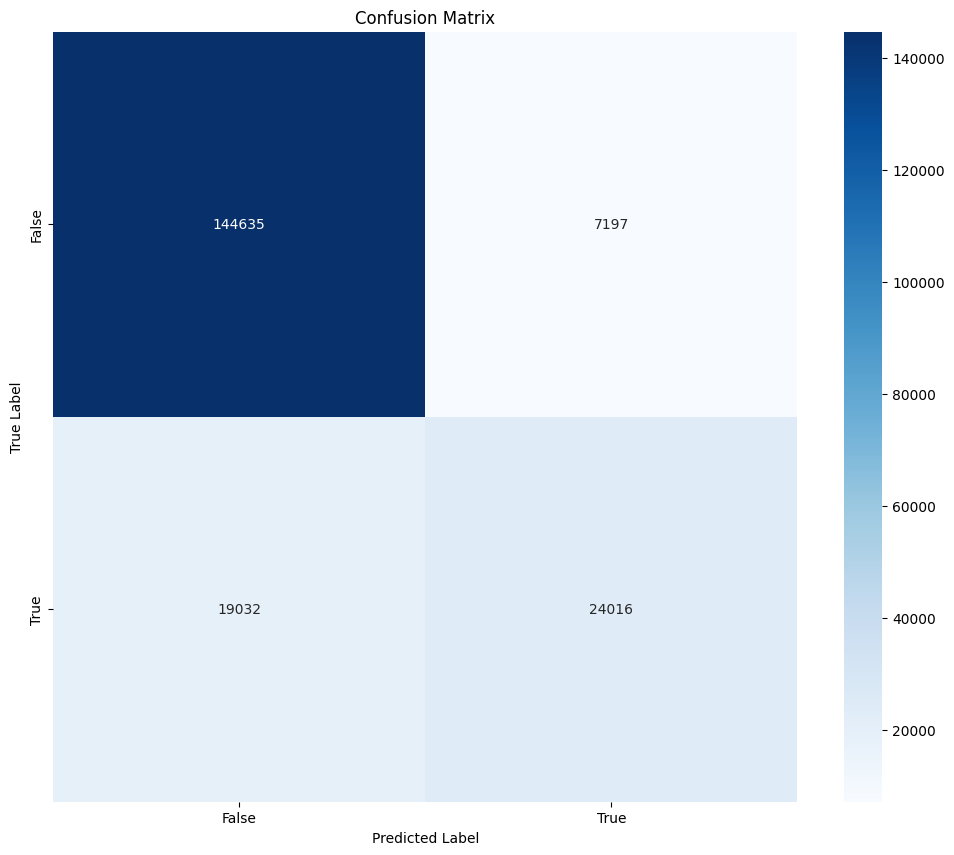

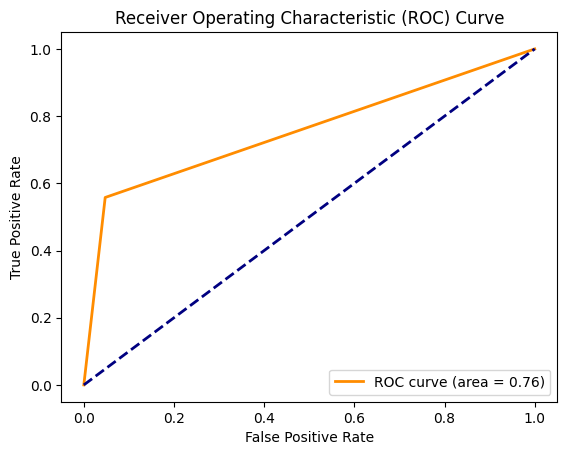

Cross-validation scores: [0.86306445 0.86442357 0.86451593 0.86544471 0.86557813]


In [ ]:
train_data = pd.read_json(file_path, lines = True)
train_data = train_data.iloc()

labels_new = []
for iter in train_data:
  for i in iter['bio_labels']:
    if i not in labels_new:
      labels_new.append(i)

#find the max size of the document across all the documents
max_len = 0
for iter in train_data:
  max_len = max(max_len,len(iter['bio_labels']))

#extract and append all the documents to a single list of docs
# train_data_docs has all the docs
#train_data_docs_pii has all the corresponding labels for the doc
train_data_docs = []
train_data_docs_pii = []
for iter in train_data:
  train_data_docs.append(iter['tokenised_text'])
  train_data_docs_pii.append(iter['bio_labels'])

#Text embedding
#converting the tokens to index based encoded vectors for the model
all_tokens = set([word.lower() for doc in train_data_docs for word in doc])
word_to_idx = {token.lower():idx+1 for idx, token in enumerate(all_tokens)}
word_to_idx

# converting the docs to their token ids
train_data_docs = np.array([[word_to_idx[token.lower()] for token in token_doc] for token_doc in train_data_docs], dtype = 'object')

#Doing label encoding for the PII classes
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(labels_new)
y_train = []
for iter in train_data_docs_pii:
  # print(iter)
  # break
  y_padded = le.transform(iter)
  y_train.append(y_padded)

train_data_docs_pii = y_train

ngram, pii_ret = create_n_grams(3,train_data_docs, train_data_docs_pii)

#creating X and Y for training and testing
X=[]
Y=[]
for idx in range(len(ngram)):
  for i_idx in range(len(ngram[idx])):
    X.append(ngram[idx][i_idx])
    Y.append(pii_ret[idx][i_idx])

X=np.array(X)
Y=np.array(Y)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)

from sklearn.ensemble import RandomForestClassifier
# define the model
model = RandomForestClassifier(criterion="entropy", random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

#Accuracy check for Random Forest model
count = 0
count_original = 0
for idx in range(len(y_pred)):
  if y_pred[idx] == True and y_test[idx] == True:
    count+=1
  if y_test[idx] == True:
    count_original+=1


print("Accuracy of PII words classification for Random Forest = " + str(count*100/count_original))

#Overall accuracy for Decision Tree model
count = 0
for idx in range(len(y_pred)):
  if y_pred[idx] == y_test[idx]:
    count+=1

print("Overall classification acccuracy for Random Forest = " + str(count*100/len(y_test)))

#Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
labels = list(set(y_test + y_pred))
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#ROC
from sklearn.metrics import roc_curve, auc

# Assuming you want to create ROC curves for a specific class (e.g., 'PERSON')
y_true_binary = [1 if label == True else 0 for label in y_test]
y_pred_binary = [1 if label == True else 0 for label in y_pred]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true_binary, y_pred_binary)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#5-Cross Validation
from sklearn.model_selection import KFold, cross_val_score

model =  RandomForestClassifier(criterion="entropy", random_state=42)
k_folds = KFold(n_splits=5)
scores = cross_val_score(model, X, Y, cv=k_folds)

print("Cross-validation scores:", scores)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



# RANDOM FOREST
Dataset : Augmented Dataset

Encoding : word level - n grams

Data Preprocessing: Yes

Accuracy of PII words classification for Random Forest = 55.69579362698724
Overall classification acccuracy for Random Forest = 86.44909688013136


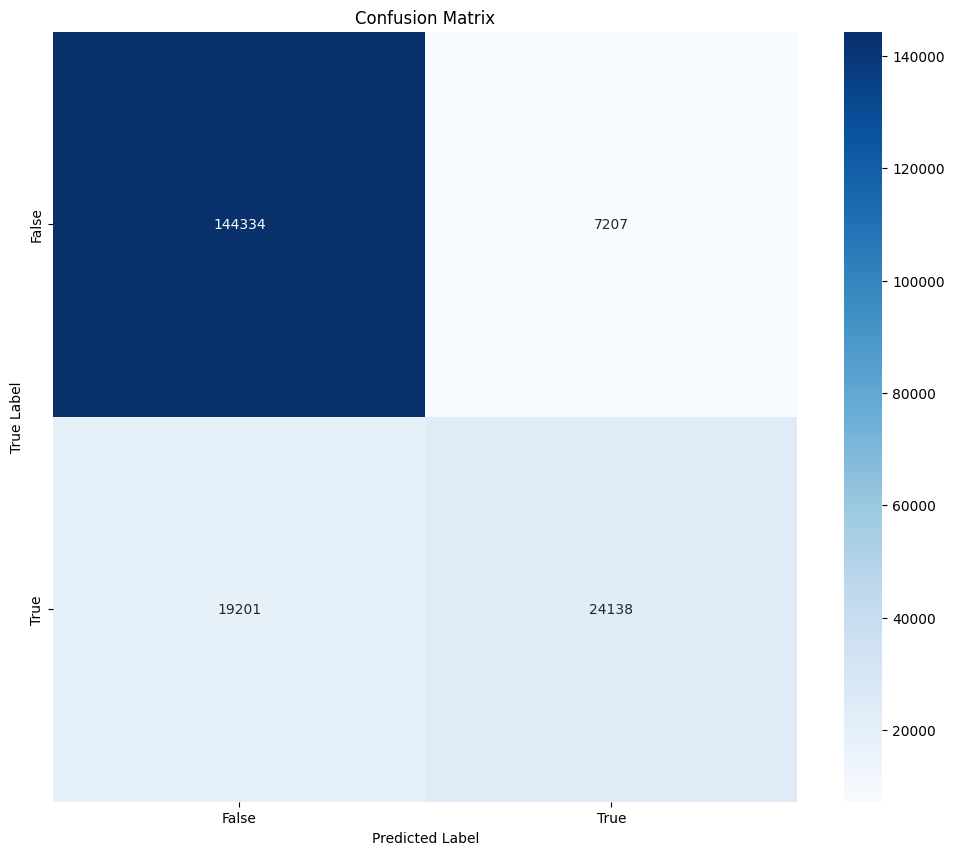

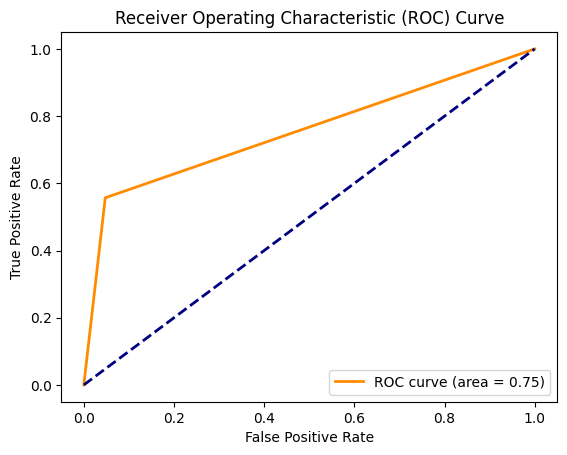

Cross-validation scores: [0.86306445 0.86442357 0.86451593 0.86544471 0.86557813]


In [ ]:
train_data = pd.read_json(file_path, lines = True)
train_data = train_data.iloc()
# for iter in train_data:
#     print(iter)
#     break


#pre-processing
train_data = preprocess_remove(train_data,"\n\n")
train_data = preprocess_remove(train_data," ")
train_data = preprocess_remove(train_data,"\t")
train_data = preprocess_remove(train_data,"\\r")


labels_new = []
for iter in train_data:
  for i in iter['bio_labels']:
    if i not in labels_new:
      labels_new.append(i)

#find the max size of the document across all the documents
max_len = 0
for iter in train_data:
  max_len = max(max_len,len(iter['bio_labels']))

#extract and append all the documents to a single list of docs
# train_data_docs has all the docs
#train_data_docs_pii has all the corresponding labels for the doc
train_data_docs = []
train_data_docs_pii = []
for iter in train_data:
  train_data_docs.append(iter['tokenised_text'])
  train_data_docs_pii.append(iter['bio_labels'])

#Text embedding
#converting the tokens to index based encoded vectors for the model
all_tokens = set([word.lower() for doc in train_data_docs for word in doc])
word_to_idx = {token.lower():idx+1 for idx, token in enumerate(all_tokens)}
word_to_idx

# converting the docs to their token ids
train_data_docs = np.array([[word_to_idx[token.lower()] for token in token_doc] for token_doc in train_data_docs], dtype = 'object')

#Doing label encoding for the PII classes
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(labels_new)
y_train = []
for iter in train_data_docs_pii:
  # print(iter)
  # break
  y_padded = le.transform(iter)
  y_train.append(y_padded)

train_data_docs_pii = y_train

ngram, pii_ret = create_n_grams(3,train_data_docs, train_data_docs_pii)

#creating X and Y for training and testing
X=[]
Y=[]
for idx in range(len(ngram)):
  for i_idx in range(len(ngram[idx])):
    X.append(ngram[idx][i_idx])
    Y.append(pii_ret[idx][i_idx])

X=np.array(X)
Y=np.array(Y)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)

from sklearn.ensemble import RandomForestClassifier
# define the model
model = RandomForestClassifier(criterion="entropy", random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

#Accuracy check for Random Forest model
count = 0
count_original = 0
for idx in range(len(y_pred)):
  if y_pred[idx] == True and y_test[idx] == True:
    count+=1
  if y_test[idx] == True:
    count_original+=1


print("Accuracy of PII words classification for Random Forest = " + str(count*100/count_original))

#Overall accuracy for Decision Tree model
count = 0
for idx in range(len(y_pred)):
  if y_pred[idx] == y_test[idx]:
    count+=1

print("Overall classification acccuracy for Random Forest = " + str(count*100/len(y_test)))

#Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
labels = list(set(y_test + y_pred))
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#ROC
from sklearn.metrics import roc_curve, auc

# Assuming you want to create ROC curves for a specific class (e.g., 'PERSON')
y_true_binary = [1 if label == True else 0 for label in y_test]
y_pred_binary = [1 if label == True else 0 for label in y_pred]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true_binary, y_pred_binary)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#5-Cross Validation
from sklearn.model_selection import KFold, cross_val_score

model =  RandomForestClassifier(criterion="entropy", random_state=42)
k_folds = KFold(n_splits=5)
scores = cross_val_score(model, X, Y, cv=k_folds)

print("Cross-validation scores:", scores)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt




# RANDOM FOREST
Dataset : Augmented Dataset

Encoding : character level

Data Preprocessing: No

Accuracy of PII words classification for Random Forest = 0.9865494321452871
Overall classification acccuracy for Random Forest = 8.530183727034121


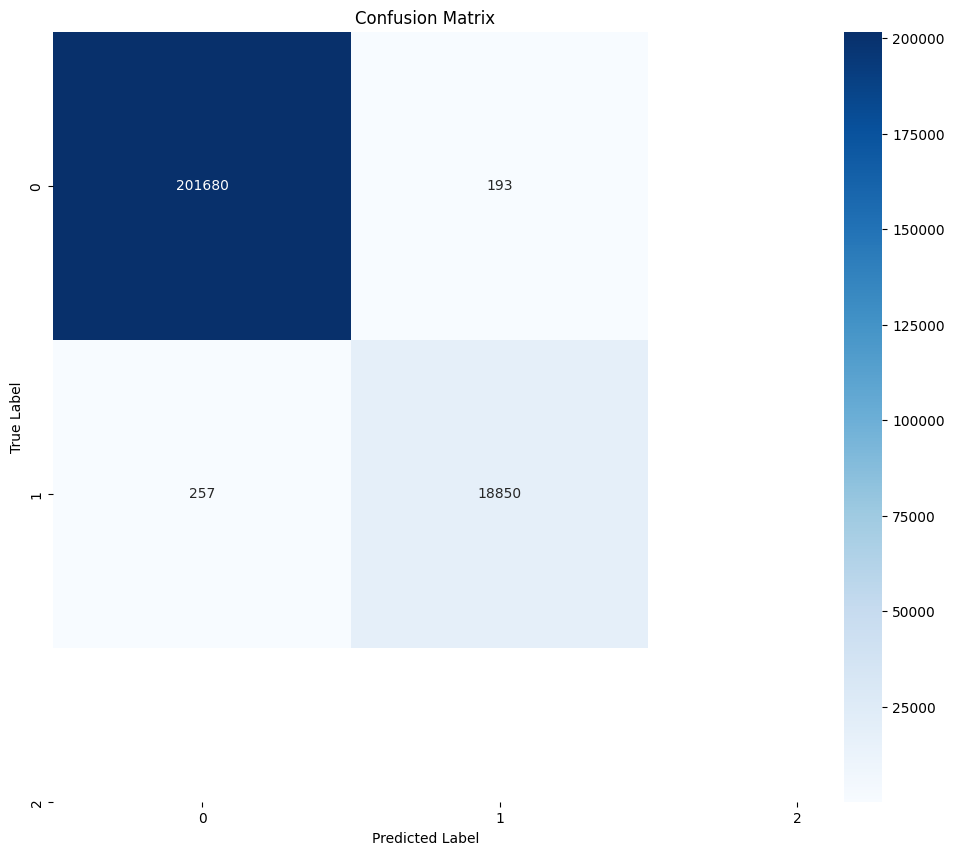

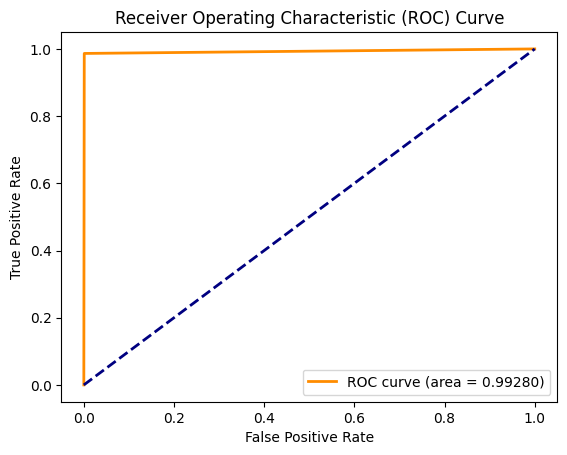

Cross-validation scores: [0.5664766  0.99894561 0.99891845 0.99896823 0.99906778]


In [ ]:
train_data = pd.read_json(file_path, lines = True)

#create the list of PIIs and the top N number of occurences of non-pii words
all_piis = []
top_non_pii = []
for iter in train_data.iloc():
  for idx, label in enumerate(iter['bio_labels']):
    if label != "O":
      all_piis.append(iter['tokenised_text'][idx].lower())
    else:
      top_non_pii.append(iter['tokenised_text'][idx].lower())

temp = max(len(iter) for iter in all_piis)
max_len = max(len(iter) for iter in top_non_pii)
max_len = max(max_len, temp)

combined_data = '#'
for iter in all_piis:
  combined_data += iter
for iter in top_non_pii:
  combined_data += iter
chars = sorted(list(set(combined_data)))
mapping = dict((c, i) for i, c in enumerate(chars))

#For debugging purposes
#Creating an index to char map

index_to_char = {v: k for k, v in mapping.items()}

for idx,iter in enumerate(all_piis):
  all_piis[idx] = [mapping[char] for char in iter]
for idx,iter in enumerate(all_piis):
  all_piis[idx] = pad(iter,max_len,mapping['#'])
all_piis = pd.DataFrame(all_piis)

for idx,iter in enumerate(top_non_pii):
  top_non_pii[idx] = [mapping[char] for char in iter]

for idx,iter in enumerate(top_non_pii):
  top_non_pii[idx] = pad(iter,max_len,mapping['#'])
top_non_pii = pd.DataFrame(top_non_pii)

top_non_pii['label'] = [0]*len(top_non_pii)
all_piis['label'] = [1]*len(all_piis)

data = pd.concat([all_piis,top_non_pii], ignore_index=True)
data.reset_index()
x_char = data[data.columns.difference(['label'])]
y_char = data['label']

from operator import index
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_char,y_char,test_size=0.2)

from sklearn.ensemble import RandomForestClassifier
# define the model
model = RandomForestClassifier(criterion="entropy", random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

count = 0
for iter in range(len(y_pred)):
  if y_test.iloc[iter] == 1 and y_pred[iter] == 1:
    count+=1

count/y_test.sum()

print("Accuracy of PII words classification for Random Forest = " + str(count/y_test.sum()))

print("Overall classification acccuracy for Random Forest = " + str(count*100/len(y_test)))


#Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
labels = list(set(y_test + y_pred))
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#ROC
from sklearn.metrics import roc_curve, auc

# Assuming you want to create ROC curves for a specific class (e.g., 'PERSON')
y_true_binary = [1 if label == True else 0 for label in y_test]
y_pred_binary = [1 if label == True else 0 for label in y_pred]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true_binary, y_pred_binary)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#5-Cross Validation
from sklearn.model_selection import KFold, cross_val_score

model =  RandomForestClassifier(criterion="entropy", random_state=42)
k_folds = KFold(n_splits=5)
scores = cross_val_score(model, x_char, y_char, cv=k_folds)

print("Cross-validation scores:", scores)

# RANDOM FOREST
Dataset : Augmented Dataset

Encoding : character level

Data Preprocessing: Yes


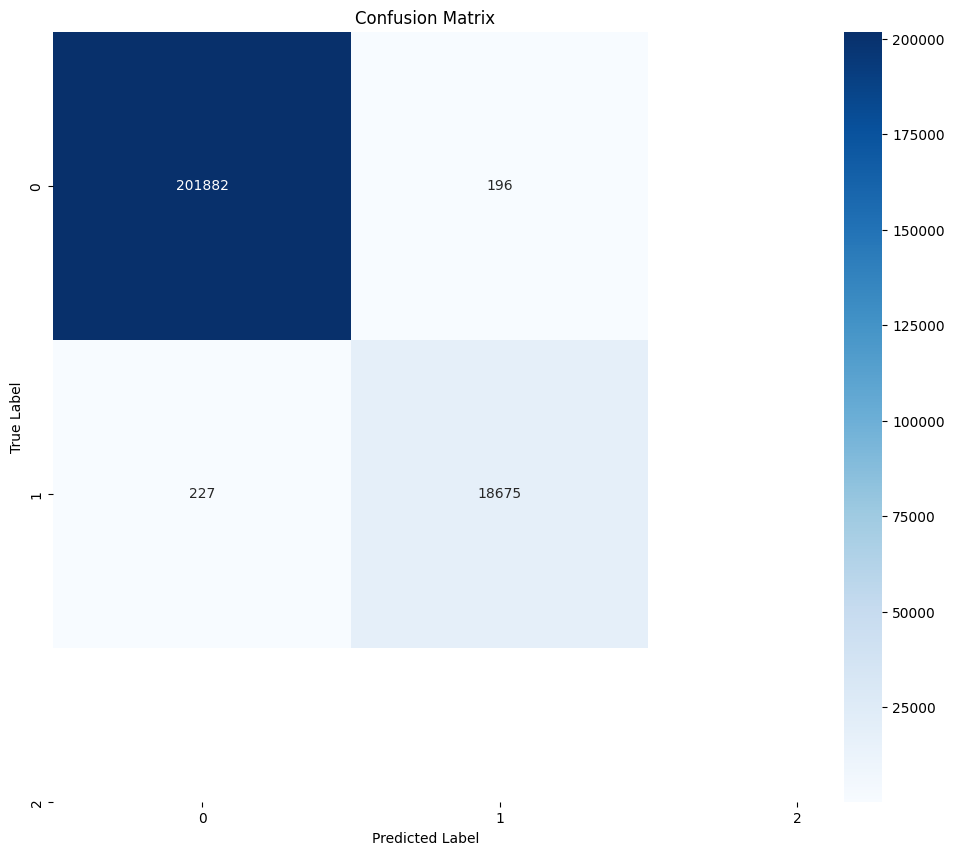

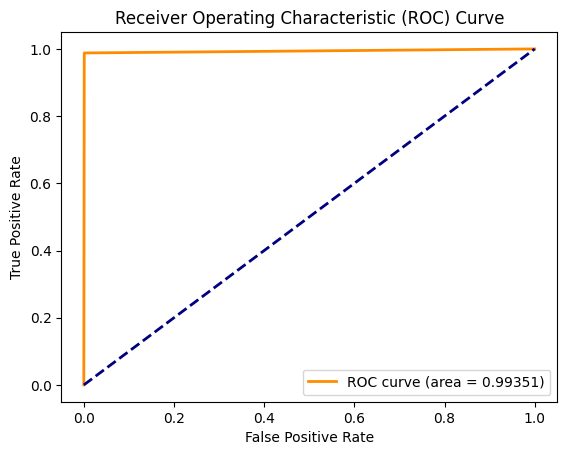

Cross-validation scores: [0.5664766  0.99894561 0.99891845 0.99896823 0.99906778]


In [ ]:
train_data = pd.read_json(file_path, lines = True)
train_data = train_data.iloc()
train_data = preprocess_remove(train_data,"\n\n")
train_data = preprocess_remove(train_data," ")
train_data = preprocess_remove(train_data,"\t")
train_data = preprocess_remove(train_data,"\\r")

#create the list of PIIs and the top N number of occurences of non-pii words
all_piis = []
top_non_pii = []
for iter in train_data:
  for idx, label in enumerate(iter['bio_labels']):
    if label != "O":
      all_piis.append(iter['tokenised_text'][idx].lower())
    else:
      top_non_pii.append(iter['tokenised_text'][idx].lower())

temp = max(len(iter) for iter in all_piis)
max_len = max(len(iter) for iter in top_non_pii)
max_len = max(max_len, temp)

combined_data = '#'
for iter in all_piis:
  combined_data += iter
for iter in top_non_pii:
  combined_data += iter
chars = sorted(list(set(combined_data)))
mapping = dict((c, i) for i, c in enumerate(chars))

#For debugging purposes
#Creating an index to char map

index_to_char = {v: k for k, v in mapping.items()}

for idx,iter in enumerate(all_piis):
  all_piis[idx] = [mapping[char] for char in iter]
for idx,iter in enumerate(all_piis):
  all_piis[idx] = pad(iter,max_len,mapping['#'])
all_piis = pd.DataFrame(all_piis)

for idx,iter in enumerate(top_non_pii):
  top_non_pii[idx] = [mapping[char] for char in iter]

for idx,iter in enumerate(top_non_pii):
  top_non_pii[idx] = pad(iter,max_len,mapping['#'])
top_non_pii = pd.DataFrame(top_non_pii)

top_non_pii['label'] = [0]*len(top_non_pii)
all_piis['label'] = [1]*len(all_piis)

data = pd.concat([all_piis,top_non_pii], ignore_index=True)
data.reset_index()
x_char = data[data.columns.difference(['label'])]
y_char = data['label']

from operator import index
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_char,y_char,test_size=0.2)

from sklearn.ensemble import RandomForestClassifier
# define the model
model = RandomForestClassifier(criterion="entropy", random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

count = 0
for iter in range(len(y_pred)):
  if y_test.iloc[iter] == 1 and y_pred[iter] == 1:
    count+=1

count/y_test.sum()

#Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
labels = list(set(y_test + y_pred))
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#ROC
from sklearn.metrics import roc_curve, auc

# Assuming you want to create ROC curves for a specific class (e.g., 'PERSON')
y_true_binary = [1 if label == True else 0 for label in y_test]
y_pred_binary = [1 if label == True else 0 for label in y_pred]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true_binary, y_pred_binary)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#5-Cross Validation
from sklearn.model_selection import KFold, cross_val_score

model =  RandomForestClassifier(criterion="entropy", random_state=42)
k_folds = KFold(n_splits=5)
scores = cross_val_score(model, x_char, y_char, cv=k_folds)

print("Cross-validation scores:", scores)